# Data Understanding

Importing the used modules

In [1]:

import pandas as pd

import glob
import os

import cv2
import numpy as np
import torch

from tqdm import tqdm

torch.backends.cudnn.benchmark = True

from timm.data import ImageDataset, create_loader

import matplotlib.pyplot as plt

%matplotlib inline

Loading the dataset

In [2]:
BASE_DIRECTORY = '../dfl-bundesliga-data-shootout/'
EXTENTSION = '.mp4'
CLIPS_PATH = BASE_DIRECTORY + 'clips'
TRAIN_PATH = BASE_DIRECTORY + 'train'
TEST_PATH = BASE_DIRECTORY + 'test'

train_csv = pd.read_csv(BASE_DIRECTORY + 'train.csv')
print(train_csv.shape)
train_csv.head()

(11218, 4)


,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,NaN
3,1606b0e6_0,210.124111,start,NaN
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']


Let's load the videos.

In [3]:
def get_video_length(video_path: str) -> int:
    video = cv2.VideoCapture(video_path)
    # frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
    return 5

def extract_images(video_path, out_dir):
    video_name = os.path.basename(video_path).split('.')[0]
    cam = cv2.VideoCapture(video_path)
    print(video_path)
    frame_count = 1
    while True:
        successed, img = cam.read()
        if not successed:
            break
        outfile = f'{out_dir}/{video_name}-{frame_count:06}.jpg'
        img = cv2.resize(img, dsize=IMG_SIZE)
        cv2.imwrite(outfile, img)
        #print(outfile)
        frame_count += 1 

video_ids = train_csv['video_id'].values
videos_durations = {video_id: get_video_length(BASE_DIRECTORY + 'train/' + video_id + EXTENTSION) for video_id in video_ids}
print(videos_durations)

[ WARN:0@2.625] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@2.625] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@2.625] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@2.625] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_16645483

KeyboardInterrupt: 

In [8]:
train_csv.isna().sum()

video_id               0
time                   0
event                  0
event_attributes    6836
dtype: int64

In [12]:
start_end_events = train_csv[train_csv['event'].isin(['start', 'end'])]
print(start_end_events.shape)
start_end_events.isna().sum()

(6836, 4)


video_id               0
time                   0
event                  0
event_attributes    6836
dtype: int64

We can see here that the training data is relatively clean. The only column which contains null values is the `event_attributes`. Moreover, the null values only occus when the associated event is `start` or `end`. 

Let's check the number of rows for each video.

['1606b0e6_0' '1606b0e6_1' '35bd9041_0' '35bd9041_1' '3c993bd2_0'
 '3c993bd2_1' '407c5a9e_1' '4ffd5986_0' '9a97dae4_1' 'cfbe2e94_0'
 'cfbe2e94_1' 'ecf251d4_0']
[1000 1249 1075  933 1042  966  858  792  737  823  763  980]
Total number of videos is 12


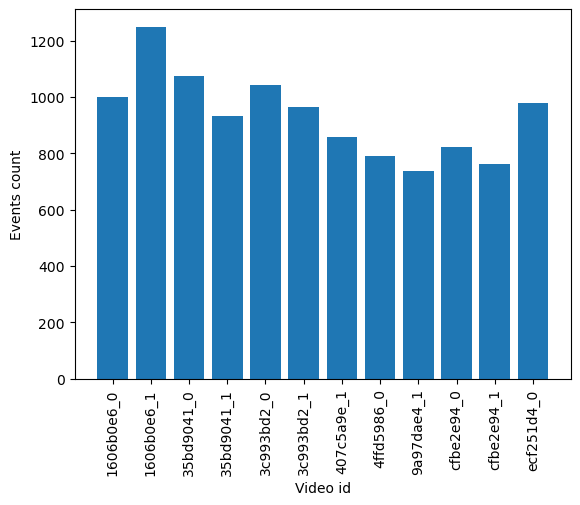

In [11]:
unique, counts = np.unique(train_csv['video_id'].values, return_counts=True)
print(unique)
print(counts)
print(f"Total number of videos is {len(counts)}")
poses = range(len(unique))
plt.bar(unique, counts, width=.8,)
plt.xticks(poses, unique, rotation=90)
plt.xlabel("Video id")
plt.ylabel("Events count")
plt.show()

Next let's analyze the number of rows for each type of event.

['challenge' 'end' 'play' 'start' 'throwin']
[ 624 3418 3586 3418  172]
Total number of event types is 5


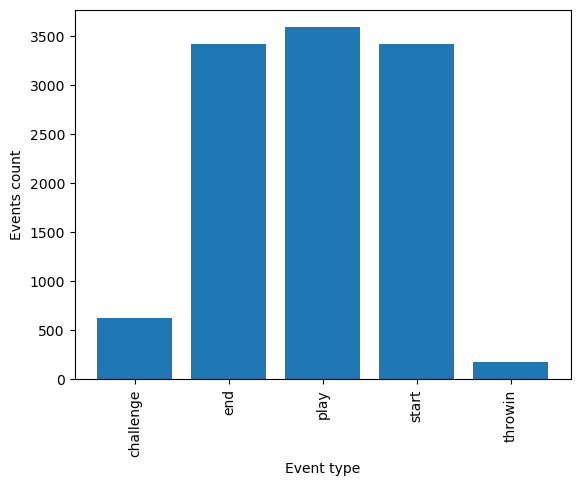

In [13]:
unique, counts = np.unique(train_csv['event'].values, return_counts=True)
print(unique)
print(counts)
print(f"Total number of event types is {len(counts)}")
poses = range(len(unique))
plt.bar(unique, counts, width=.8,)
plt.xticks(poses, unique, rotation=90)
plt.xlabel("Event type")
plt.ylabel("Events count")
plt.show()

In [39]:

unique, counts = np.unique(train_csv['time'].values, return_counts=True)
mx_time = np.max(unique)
print(mx_time)
segment = 20
iterations = int(np.ceil(mx_time / segment))

3575.0007270923616


Text(0, 0.5, 'events count')

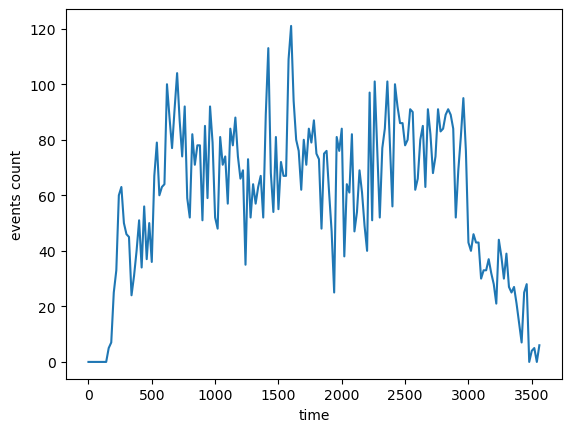

In [40]:

ranges = [(i * segment, (i + 1) * segment - 1) for i in range(iterations)]
times = [i * segment for i in range(iterations)]
counts = []
for l, r in ranges:
    cur_current = train_csv[(train_csv['time'] >= l) & (train_csv['time'] <= r)].shape[0]
    counts.append(cur_current)

plt.plot(times, counts)
plt.xlabel("time")
plt.ylabel("events count")